### Two Stream Instability
Simulated in quasi-2D with only one cell in y-axis.

Parameters are based on the simulation of two_stream_ee_es.inp distributed with XOOPIC.
Two electron beams with opposite velocities interact with each other. There is also a fluid species of ions that neutralizes electrons' charge. In XOOPIC simulation ions (He+) are also a kinetic species.

In [1]:
import Random
Random.seed!(0)
cd("/Users/bach/OneDrive - Politechnika Warszawska/projects/2019/iskra")
include("problem/configuration.jl")
include("problem/units_and_constants.jl")
config = Config()
############################################
νtherm = thermal_speed(300K, me)
#νdrift = 2e5 #m/s -- two streams merge
νdrift = 2e6 #m/s -- vortices appear
#νdrift = 2e7 #m/s -- two streams are stable
mHe = 4.002602me/5.48579903e-04
nHe = 1e24
ne = 2nHe
f  = 9kHz
ω  = 2π * f * sqrt(2e-6ne)
ds = 5e-3c0/ω
ts = 500
nx = 256
ny = 1
Δh = ds

simulationVolume = nx * Δh * ny * Δh
numCells         = nx * ny
electronParticles    = 20 * numCells
totalNumElectrons    = ne * simulationVolume
electronNumRatio     = totalNumElectrons / electronParticles
Δt = .1Δh/νdrift/sqrt(2.0)
Lx = nx*Δh
Ly = ny*Δh
############################################
println("Δt: ", Δt, "\nΔh: ", Δh, "\nLx: ", Lx)
println("νtherm: ", round(νtherm/c0; sigdigits=1), "c")
println("νdrift: ", round(νdrift/c0; sigdigits=3), "c")
println("electrons: ", electronParticles, " wg: ", electronNumRatio)

Δt: 4.68590349649729e-16
Δh: 1.325373655343595e-8
Lx: 3.392956557679603e-6
νtherm: 0.0003c
νdrift: 0.00667c
electrons: 5120 wg: 1.7566153262788422e7


In [2]:
xs = 0m:Δh:Lx
ys = 0m:Δh:Ly
e  = create_kinetic_species("e-", 20_000,-1qe, 1me, electronNumRatio);
iHe = FluidSpecies("He+", 1.0, +1qe, mHe, nHe*ones(nx+1, ny+1), 0.0K)

fwd = create_thermalized_beam(e, [Lx Ly], [+νdrift 0 0]; T=300.0K, rate=electronParticles/2/Δt)
rev = create_thermalized_beam(e, [Lx Ly], [-νdrift 0 0]; T=300.0K, rate=electronParticles/2/Δt)
using RegularGrid, FiniteDifferenceMethod, ParticleInCell
import ParticleInCell: create_surface_tracker
config.grid    = create_uniform_grid(xs, ys)
config.cells   = create_staggered_grid(config.grid)
config.solver  = create_poisson_solver(config.grid, ε0)
config.pusher  = create_boris_pusher()
config.species = [e, iHe]
############################################
nx, ny = size(config.grid)
mx, my = size(config.cells)
εr  = ones(mx, my)
bcs = zeros(Int8, nx, ny)
bcs[ 1, :] .= 1
bcs[nx, :] .= 2
set_permittivity(εr)
apply_periodic(config.solver, 1)
apply_periodic(config.solver, 2)
############################################
using ParticleInCell
using Diagnostics
using XDMF
using Diagnostics

function ParticleInCell.after_loop(i, t, dt)
  cd("/tmp")
  new_iteration("10_two_streams", i, t, dt) do it
    save_records(it, "e-/")
    save_record(it, "rho")
    save_record(it, "phi")
    save_record(it, "E")
    save_record(it, "nHe+")
    save_record(it, "ne-")
  end
end

init(fwd, e, Δt)
init(rev, e, Δt)
@time solve(config, Δt, ts)

Registering diagnostics e-/id
Registering diagnostics e-/mass
Registering diagnostics e-/charge
Registering diagnostics e-/weighting
Registering diagnostics e-/momentum
Registering diagnostics e-/position
Registering diagnostics e-/positionOffset/x
Registering diagnostics e-/positionOffset/y
Registering diagnostics e-/positionOffset/z
Registering diagnostics dHe+
Registering diagnostics vHe+
Registering diagnostics ne-
Registering diagnostics nHe+
Registering diagnostics rho
Registering diagnostics phi
Registering diagnostics E
Time Step #1
Time Step #2
Time Step #3
Time Step #4
Time Step #5
Time Step #6
Time Step #7
Time Step #8
Time Step #9
Time Step #10
Time Step #11
Time Step #12
Time Step #13
Time Step #14
Time Step #15
Time Step #16
Time Step #17
Time Step #18
Time Step #19
Time Step #20
Time Step #21
Time Step #22
Time Step #23
Time Step #24
Time Step #25
Time Step #26
Time Step #27
Time Step #28
Time Step #29
Time Step #30
Time Step #31
Time Step #32
Time Step #33
Time Step #34

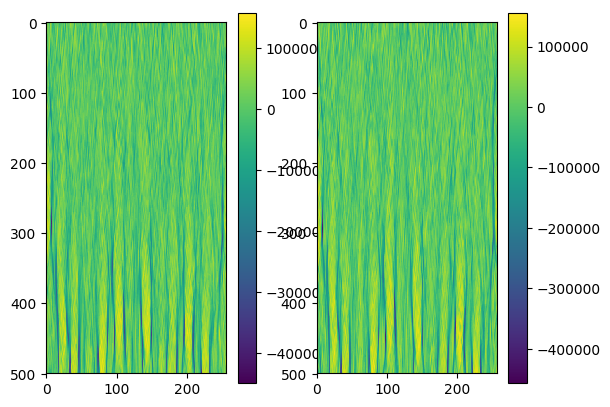

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/bach/.julia/packages/PyPlot/XHEG0/src/init.jl:192


In [3]:
# Visualization of Particle-in-Cell results
using PyPlot
using PyCall
ov = pyimport("openpmd_viewer")
ts = ov.OpenPMDTimeSeries("/tmp/10_two_streams/hdf5")
pt = ov.ParticleTracker(ts, iteration=1, select=Dict("id"=>[0, electronParticles]),
    species="e-", preserve_particle_index=false)
it, np = length(ts.iterations), pt.N_selected;
px = zeros(it, np)
py = zeros(it, np)
vx = zeros(it, np)
vy = zeros(it, np)
Ex = zeros(it, ny, nx)
phi = zeros(it, ny, nx)
rho = zeros(it, ny, nx)
nHe = zeros(it, ny, nx)
ne  = zeros(it, ny, nx)
for i=1:it
    x, y, ux, uy = ts.get_particle( ["x", "y", "ux", "uy"],
        select=pt, iteration=ts.iterations[i], species="e-")
    px[i, :] = x[:]
    py[i, :] = y[:]
    vx[i, :] = ux[:]
    vy[i, :] = uy[:]
    Ex[i, :, :],= ts.get_field("E", iteration=ts.iterations[i], coord="x")
   phi[i, :, :],= ts.get_field("phi", iteration=ts.iterations[i])
   rho[i, :, :],= ts.get_field("rho", iteration=ts.iterations[i])
   nHe[i, :, :],= ts.get_field("nHe+", iteration=ts.iterations[i])
    ne[i, :, :],= ts.get_field("ne-", iteration=ts.iterations[i])
end

subplot(1,2,1); imshow(rho[:,1,:]); colorbar();
subplot(1,2,2); imshow(rho[:,2,:]); colorbar();

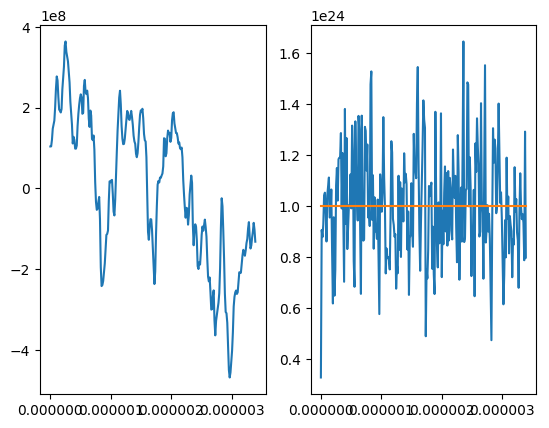

In [4]:
subplot(1,2,1); plot(xs, Ex[1,2,:]);
subplot(1,2,2); plot(xs, ne[1,2,:], xs, nHe[1,2,:]);

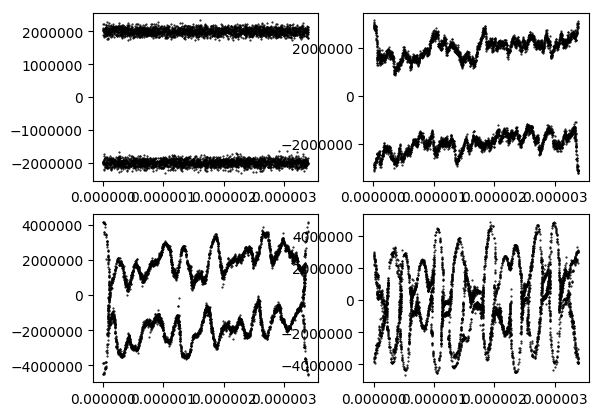

In [5]:
subplot(2,2,1); plot(px[  1,:], c0*vx[  1,:], "k.", markersize=1);
subplot(2,2,2); plot(px[100,:], c0*vx[100,:], "k.", markersize=1);
subplot(2,2,3); plot(px[300,:], c0*vx[300,:], "k.", markersize=1);
subplot(2,2,4); plot(px[500,:], c0*vx[500,:], "k.", markersize=1);


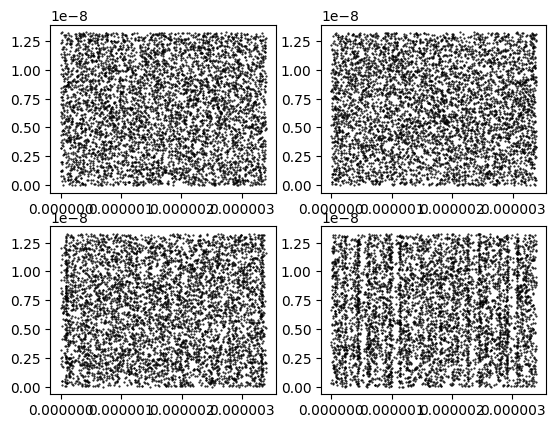

In [6]:
subplot(2,2,1); plot(px[  1,:], py[  1,:], "k.", markersize=1);
subplot(2,2,2); plot(px[100,:], py[100,:], "k.", markersize=1);
subplot(2,2,3); plot(px[300,:], py[300,:], "k.", markersize=1);
subplot(2,2,4); plot(px[500,:], py[500,:], "k.", markersize=1);